Calculate event rate of generalized Yukawa scattering using Born approximation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dm_xsec.rate_massless_mediator import *

In [3]:
def get_nevents(q, drdq, q_thr, exposure, project_z=True):
    # <|cos(theta)|> = 0.5 if q is isotropic
    # so total `q` would look half as small in the z direction
    if project_z:
        q = q * 0.5
        
    drdq[q < q_thr] = 0
    total_rate = np.trapz(drdq, q)
    
    # Exposure in hours
    return total_rate * exposure

In [4]:
def get_total_events(sphere_type, mx_gev, alpha_t, m_phi, q_thr, exposure, project_z=True):
    outdir = r"/home/yt388/palmer_scratch/data/born"
    events = np.empty((mx_gev.size, alpha_t.size))

    for i, mx in enumerate(mx_gev):
        for j, alpha in enumerate(alpha_t):
            #if m_phi == 100:
            #    drdq_file = np.load(outdir + f'/drdq_{sphere_type}_{R_um:.2e}_{mx:.5e}_{alpha:.5e}.npz', allow_pickle='True')
            #else:
            #    drdq_file = np.load(outdir + f'/drdq_{sphere_type}_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{m_phi:.0e}.npz', allow_pickle='True')
            
            drdq_file = np.load(outdir + f'/drdq_{sphere_type}_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{m_phi:.0e}.npz', allow_pickle='True')

            # GeV; Counts/hour/GeV
            qq, drdq = drdq_file['q'], drdq_file['drdq']
            events[i][j] = get_nevents(qq, drdq, q_thr, exposure, project_z)
    
    return events

In [5]:
def interp_log(alpha_n, events):
    if alpha_n.size == 0:
        return np.asarray([]), np.asarray([])
    
    alpha_log  = np.log10(alpha_n)
    events_log = np.log10(events)
    
    alpha_interp  = np.linspace(alpha_log[0], alpha_log[-1], 50000)
    events_interp = np.interp(alpha_interp, alpha_log, events_log)
    
    return np.power(10, alpha_interp), np.power(10, events_interp)

def get_limit(mx, alpha_n, events):
    cl = 3.0  # 95% CL without background
    
    alpha_lim = np.empty_like(mx)
    
    # Solve for coupling for each DM mass where `events` = cl
    for i, m in enumerate(mx):
        events_mx = events[i]
        
        if np.max(events_mx) < 1e-2:
            alpha_lim[i] = np.nan

        else:
            # Solve by interpolation in log scale
            events_log = np.log10(events_mx)
            alpha_log  = np.log10(alpha_n)
            
            alpha_lim_log  = np.interp(np.log10(cl), events_log, alpha_log)
            alpha_lim[i] = np.power(10, alpha_lim_log)
            
            if (alpha_lim[i] > 1e-4 or alpha_lim[i] == 1e-4):
                alpha_lim[i] = np.nan
                
    return interp_log(mx[~np.isnan(alpha_lim)], alpha_lim[~np.isnan(alpha_lim)])

In [6]:
sphere_type= 'nanosphere'
R_um = 0.0075

mx_gev  = np.logspace(-7, 0, 20)
alpha_t = np.logspace(-15, -8, 20)
mphi = 100

In [7]:
q_thr = 100 / 1e9   # Momentum threshold, in GeV
exposure = 1e5 * 12 * 24 * 30 # 1e5 sphere - year

events_1      = get_total_events(sphere_type, mx_gev, alpha_t, 1,   q_thr, exposure, False)
events_10     = get_total_events(sphere_type, mx_gev, alpha_t, 10,   q_thr, exposure, False)
events_100    = get_total_events(sphere_type, mx_gev, alpha_t, 100,   q_thr, exposure, False)
events_1000   = get_total_events(sphere_type, mx_gev, alpha_t, 1000,   q_thr, exposure, False)
events_10000  = get_total_events(sphere_type, mx_gev, alpha_t, 10000,   q_thr, exposure, False)
events_100000 = get_total_events(sphere_type, mx_gev, alpha_t, 100000,   q_thr, exposure, False)

/tmp/ipykernel_21265/193875427.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0].contourf(mx_gev, alpha_t, np.log(events_1000.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_21265/193875427.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[1].contourf(mx_gev, alpha_t, np.log(events_100.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_21265/193875427.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[2].contourf(mx_gev, alpha_t, np.log(events_10.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_21265/193875427.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(1e-7, 0)
/tmp/ipykernel_21265/193875427.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Text(0.5, 1.0, '$m_\\phi =$10 eV')

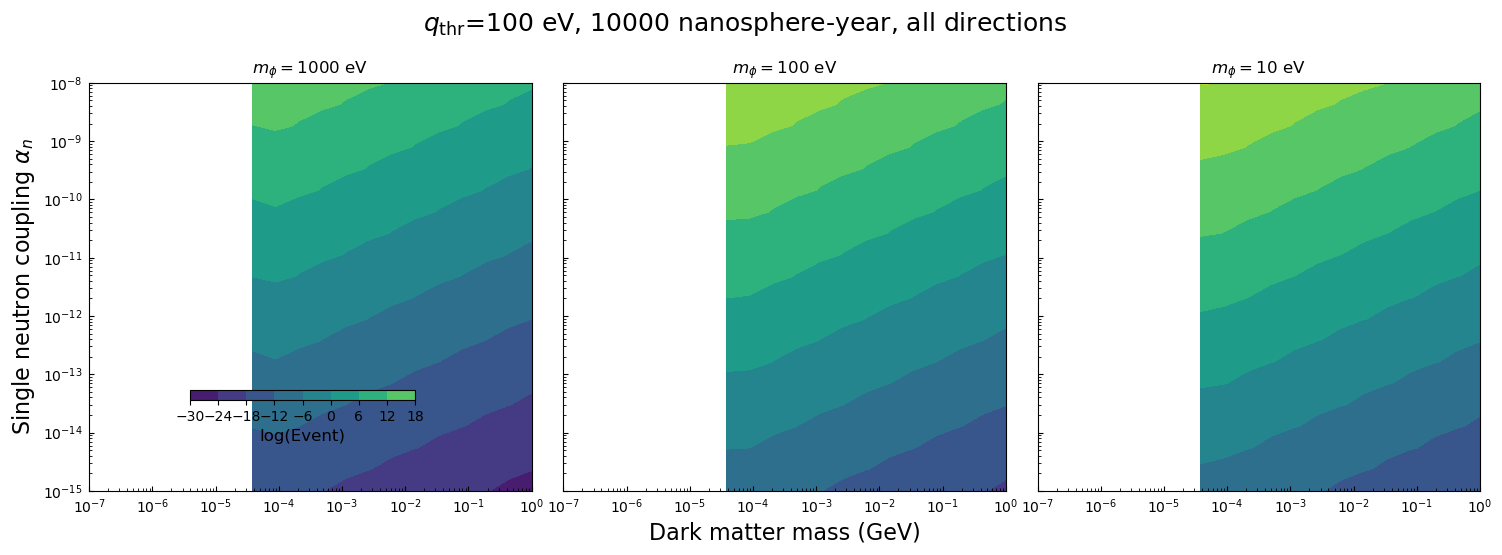

In [13]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
vmax, vmin = 32, -32

im0 = axs[0].contourf(mx_gev, alpha_t, np.log(events_1000.T),   vmax=vmax, vmin=vmin)
im1 = axs[1].contourf(mx_gev, alpha_t, np.log(events_100.T),    vmax=vmax, vmin=vmin)
im2 = axs[2].contourf(mx_gev, alpha_t, np.log(events_10.T),     vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-7, 0)
    ax.set_ylim(1e-15, 1e-8)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 0:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 1:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.32, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im0, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()
fig.suptitle(r'$q_{\mathrm{thr}}$=100 eV, 10000 nanosphere-year, all directions', fontsize=18, y=1.1)

axs[0].set_title('$m_\phi =$1000 eV')
axs[1].set_title('$m_\phi =$100 eV')
axs[2].set_title('$m_\phi =$10 eV')

Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

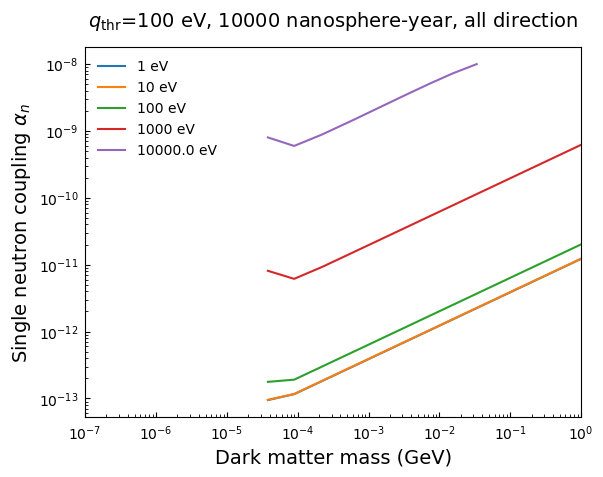

In [16]:
mx_gev_interp, alpha_lim = [], []
for events in [events_1, events_10, events_100, events_1000, events_10000]:
    lim = get_limit(mx_gev, alpha_t, events)
    
    mx_gev_interp.append(lim[0])
    
    lim[1][lim[1] == 1e-8] = np.nan
    alpha_lim.append(lim[1])

fig, ax = plt.subplots()

mass_plotted = [1, 10, 100, 1000, 1e4]
for i, lim in enumerate(alpha_lim):
    ax.loglog(mx_gev_interp[i], lim, label=f'{mass_plotted[i]} eV')

ax.set_xlim(1e-7, 1)
ax.set_ylim(1e-15, 1e-8)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=100 eV, 10000 nanosphere-year, all direction', fontsize=14, pad=15)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [17]:
np.savez(f'alpha_n_15nm_100ev_born_1e5sphereyr_alldirs.npz',
         mediator_mass_ev = np.asarray([1, 10, 100, 1000, 1e4]),
         mx_gev = np.asarray(mx_gev_interp),
         alpha_n_lim = np.asarray(alpha_lim)
        )